## Example notebook to read GA optimization results

In [1]:
from copy import deepcopy
import matplotlib.pyplot as plt
import sys
import numpy as np
import pandas as pd
import os

sys.path.append('../ga/mpi_scripts/')
from io_utils import collect_results
from gene_utils import update_C_from_genes
from ina_model import InaModel

In [2]:
case_dir = '../results/ga/activation#1/' # ga output directory 
pd.DataFrame(os.listdir(case_dir), columns = ['cases'])

,cases
0,230709_021417
1,230709_115003


In [3]:
case = '230709_115003' # filename of the case (date_time when ga was run)

result = collect_results(case, 
                         case_dir, 
                         dump_keys=['best', 'dump'])

config = result['config'] # load config

config

{'n_organisms': 32,
 'n_elites': 2,
 'n_generations': 50,
 'crossover_rate': 1.0,
 'mutation_rate': 1.0,
 'gamma': 0.05,
 'output_folder_name': '../../results/ga/activation#1',
 'loss': 'RMSE_GRAD',
 'filename_so': '/home/nik/Documents/WORK/PCoptim/src/model_ctypes/PC_model/libina.so',
 'filename_legend_states': '/home/nik/Documents/WORK/PCoptim/src/model_ctypes/PC_model/legend_states.csv',
 'filename_legend_algebraic': '/home/nik/Documents/WORK/PCoptim/src/model_ctypes/PC_model/legend_algebraic.csv',
 'filename_legend_constants': '/home/nik/Documents/WORK/PCoptim/src/model_ctypes/PC_model/legend_constants.csv',
 'columns_model': 'I_out',
 'experimental_conditions': {'common': {'params': {'a0_m': {'bounds': [0.1,
      2.0],
     'is_multiplier': True},
    'b0_m': {'bounds': [0.1, 2.0], 'is_multiplier': True},
    'delta_m': {'bounds': [0.1, 2.0], 'is_multiplier': True},
    's_m': {'bounds': [0.1, 2.0], 'is_multiplier': True},
    'tau_m_const': {'bounds': [0.1, 2.0], 'is_multiplier'

In [4]:
config

{'n_organisms': 32,
 'n_elites': 2,
 'n_generations': 50,
 'crossover_rate': 1.0,
 'mutation_rate': 1.0,
 'gamma': 0.05,
 'output_folder_name': '../../results/ga/activation#1',
 'loss': 'RMSE_GRAD',
 'filename_so': '/home/nik/Documents/WORK/PCoptim/src/model_ctypes/PC_model/libina.so',
 'filename_legend_states': '/home/nik/Documents/WORK/PCoptim/src/model_ctypes/PC_model/legend_states.csv',
 'filename_legend_algebraic': '/home/nik/Documents/WORK/PCoptim/src/model_ctypes/PC_model/legend_algebraic.csv',
 'filename_legend_constants': '/home/nik/Documents/WORK/PCoptim/src/model_ctypes/PC_model/legend_constants.csv',
 'columns_model': 'I_out',
 'experimental_conditions': {'common': {'params': {'a0_m': {'bounds': [0.1,
      2.0],
     'is_multiplier': True},
    'b0_m': {'bounds': [0.1, 2.0], 'is_multiplier': True},
    'delta_m': {'bounds': [0.1, 2.0], 'is_multiplier': True},
    's_m': {'bounds': [0.1, 2.0], 'is_multiplier': True},
    'tau_m_const': {'bounds': [0.1, 2.0], 'is_multiplier'

### The loss function decrease during optimization

In [5]:
config['loss']

'RMSE_GRAD'

Text(0.5, 0, 'generation')

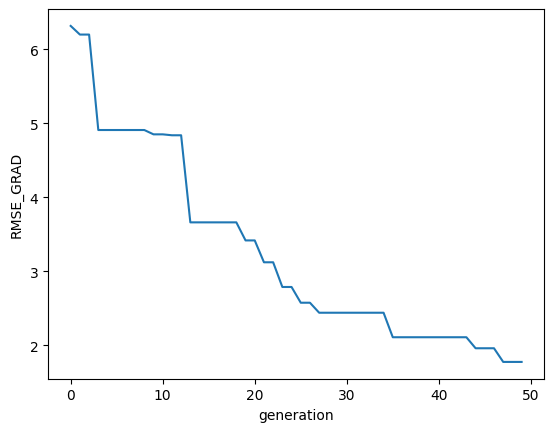

In [6]:
loss = result['dump']['best']['loss'] # loss during generations

plt.plot(loss)
plt.ylabel(config['loss'])
plt.xlabel('generation')

### Load the best fit solution vector of model parameters

In [7]:
experiment_conditions_list = list(config['experimental_conditions'].keys())
experiment_conditions_list

['common', 'individual']

"experimental_condition" dictionary is defined in 004_Create_json_file.ipynb. Simultanious multiple trace optimization is supported. In this case set of experimental setup model parameters are described in "individual#" nested dictionaries. To load soluton vector of particular trace pass the name of the  "individual#" dictionary as the third argument of "update_C_from_genes" function. In the example below the name of the dictionary is "individual" since single trace optimization was used.

In [8]:
experiment_condition = 'individual' 

sol_best = result['sol_best'] # best solution vector
legend_constants = config['runtime']['legend']['constants']
C = deepcopy(legend_constants)
update_C_from_genes(C, sol_best, experiment_condition, config)

### Output model variables

In [9]:
protocol = config['experimental_conditions'][experiment_condition]['protocol']  #protocol
initial_state_protocol = config['experimental_conditions'][experiment_condition]['initial_state_protocol']  #protocol

legend_states = config['runtime']['legend']['states'] 
legend_algebraic =  config['runtime']['legend']['algebraic'] 
A = deepcopy(legend_algebraic)
S = deepcopy(legend_states)

filename_so = config['filename_so'] 
Ina = InaModel(filename_so)

phenotype_best = Ina.run(A,
                         S,
                         C,
                         protocol, 
                         initial_state_protocol, 
                        )

shape = np.shape(protocol.drop('t', axis=1))
dt = protocol['t'][1]
t = np.arange(0, shape[0]*shape[1]*dt, dt)

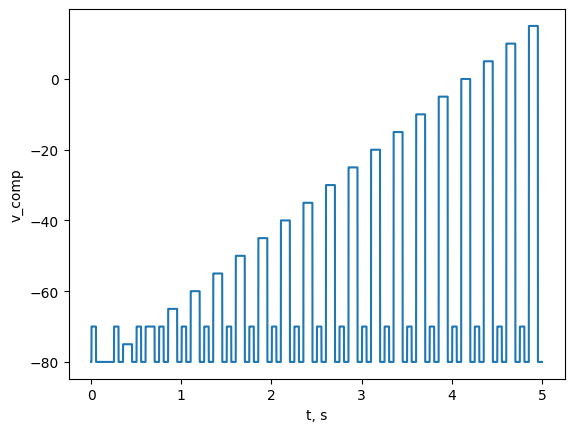

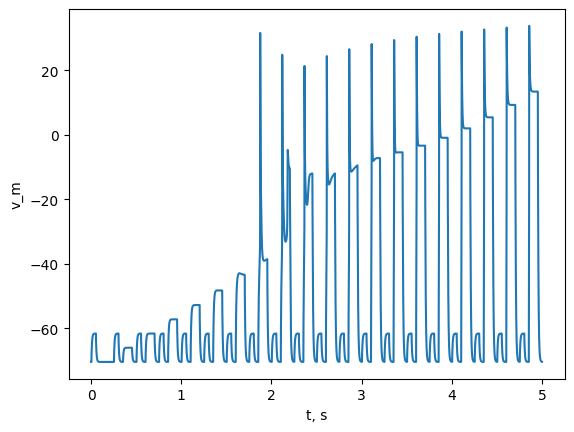

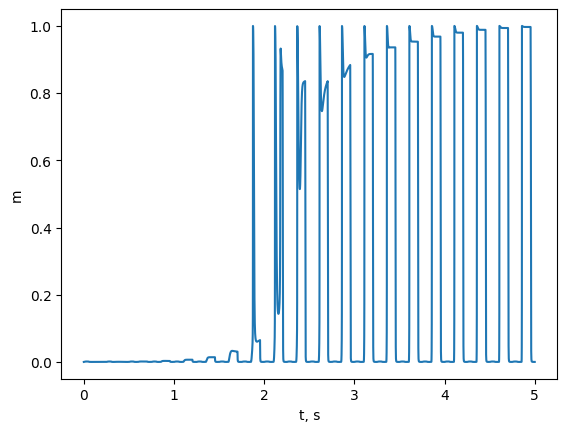

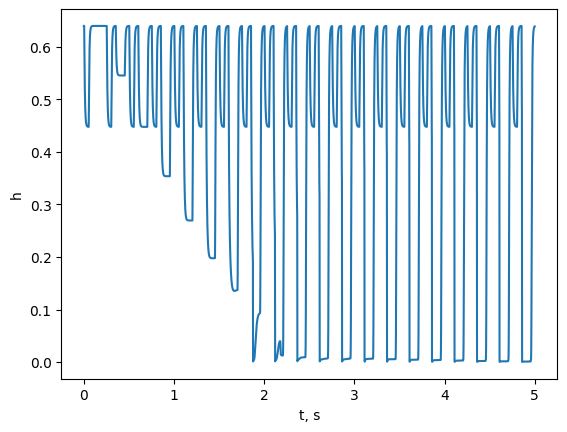

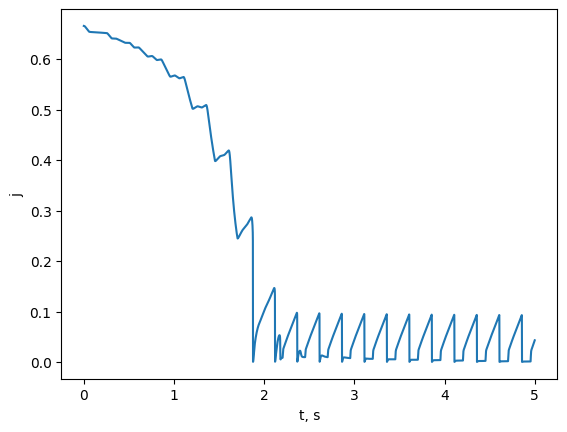

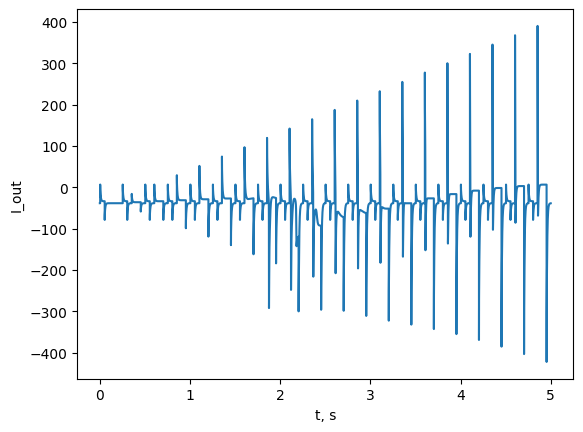

In [10]:
for state in phenotype_best:
    plt.figure()
    plt.plot(t, phenotype_best[state])
    
    plt.xlabel('t, s')
    plt.ylabel(state)
    

### Compare experimental trace with best fit model simulation

(1.0, 1.5)

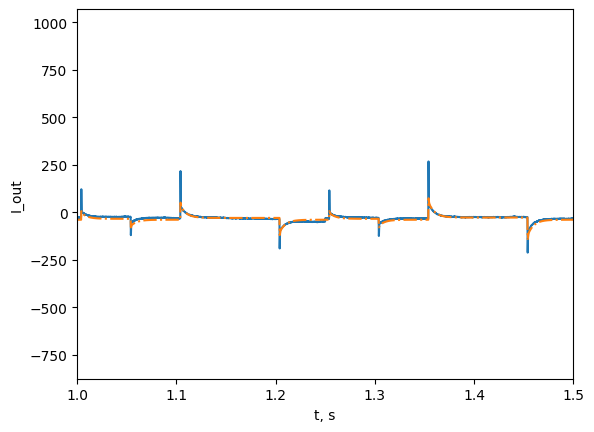

In [11]:
experimental_phenotype = config['experimental_conditions'][experiment_condition]['phenotype'] # experimentral data

plt.plot(t, experimental_phenotype)
plt.plot(t, phenotype_best['I_out'], '-.')

plt.xlabel('t, s')
plt.ylabel(state)
plt.xlim(1.0, 1.5)

### Output the sodium current voltage dependent characteristics
Model equations used below are defined in '../src/python_func/models.py' file. Modify this file according to your equations if custom model is used.

In [12]:
sys.path.append('../src/python_func/')
from models import model1

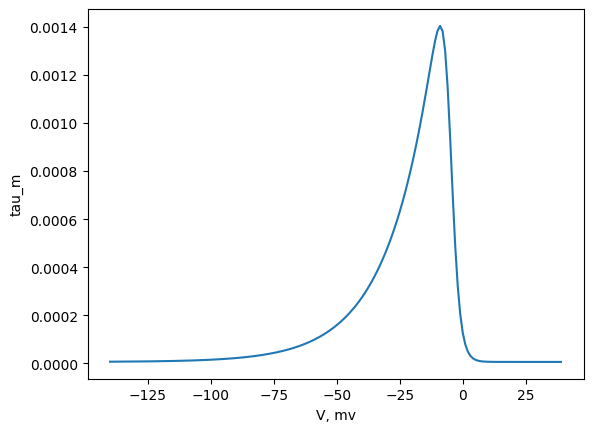

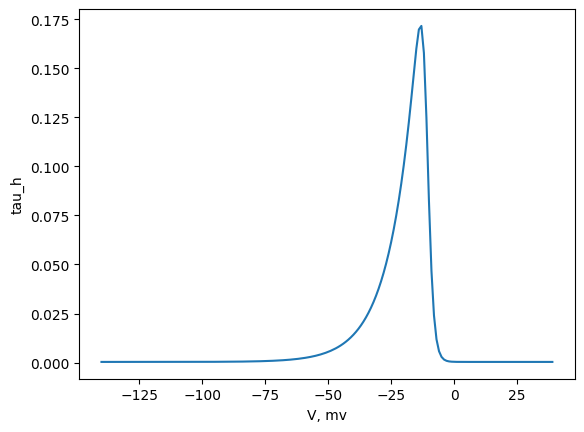

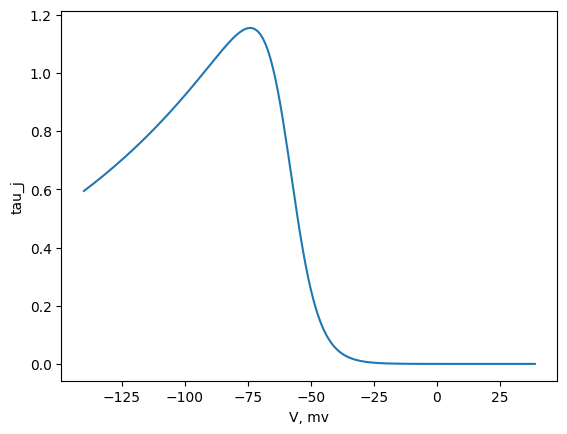

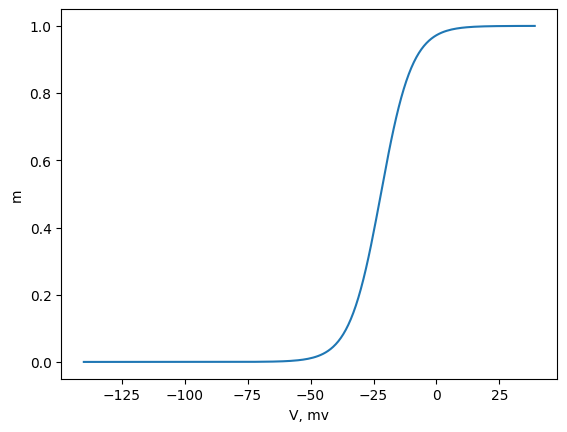

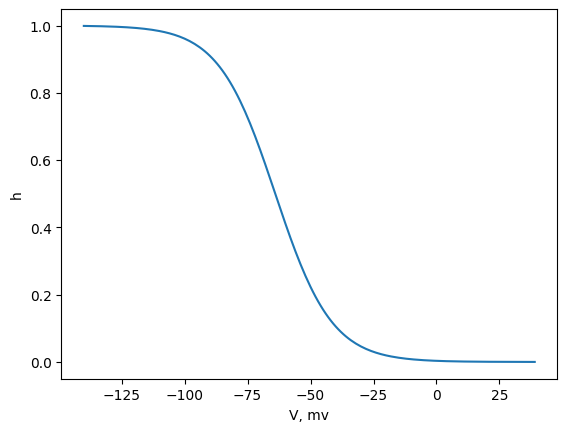

In [13]:
v = np.arange(-140, 40)
current_parameters = model1(v, C)
for param_name in current_parameters:
    plt.figure()
    plt.plot(v, current_parameters[param_name])
    plt.xlabel('V, mv')
    plt.ylabel(param_name)